<a href="https://colab.research.google.com/github/carolyn-wang/civictech/blob/main/CivicTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
from fbprophet import Prophet
import pandas as pd
import datetime as dt
import MySQLdb
from sqlalchemy import create_engine
import urllib.parse

Uploading data from MySQL DB

In [184]:
password = urllib.parse.quote_plus("a#b%39r9f<3@l7D$Y=#")
engine = create_engine('mysql://Cal_User:' + password + '@ls-ea2c4af3a64009819d9118664bc0421809a1d1e0.c6iwlwfmvhjp.us-west-2.rds.amazonaws.com/BFP_Tables')
df_mysql = pd.read_sql('SELECT * FROM Cal_Visit', con=engine)
# df_mysql.head()
df_mysql.tail(70)

,ClientID,VisitDate,VisitNumChild,VisitNumAdult,VisitType,City,Zip
77151,31596,2021-03-01 00:00:00,5.0,2,P,Berkeley,94704
77152,36392,2021-03-01 00:00:00,0.0,1,P,Kensington,94708
77153,30905,2021-03-01 00:00:00,2.0,2,P,Berkeley,94703
77154,35429,2021-03-03 00:00:00,0.0,2,P,Berkeley,94703
77155,34899,2021-03-03 00:00:00,2.0,2,P,Albany,94705
...,...,...,...,...,...,...,...
77216,36588,2021-03-03 00:00:00,0.0,2,P,Berkeley,94703
77217,36672,2021-03-03 00:00:00,0.0,1,P,Berkeley,94703
77218,36701,2021-03-03 00:00:00,0.0,1,P,Berkeley,94705
77219,34558,2021-03-03 00:00:00,0.0,1,P,Berkeley,94709


# Total Visits Per Day


Total Visits per Day Data (cleaned)


In [ ]:
#Method 1: Group by date and get total number
df = pd.DataFrame(df_mysql) #convert SQL to data frame
df.drop_duplicates(inplace=True) #drops duplicate entries


#extract copy of only 'VisitDate' column
visit_dates = pd.DataFrame(data=df['VisitDate']).copy()

#Adds 1 visitor for each new visitor, 0.5 visitor for each returning for second bag
visit_dates.insert(1, 'TotalVisits', 1, allow_duplicates=False)

total_visits = visit_dates.groupby(by='VisitDate', as_index = False).count()

#excludes trivial cases (VisitDate typos)
start = total_visits['VisitDate'].searchsorted(dt.datetime(2004, 1, 1))
end = total_visits['VisitDate'].searchsorted(dt.datetime(3000, 1, 1))
total_visits = total_visits.iloc[start:end]

total_visits['VisitDate'] = pd.to_datetime(total_visits['VisitDate']).dt.normalize() #dropping 00:00:00 time

total_visits.head(30)


Slicing Total Visits within Start & End Date

In [223]:
start = total_visits['VisitDate'].searchsorted(dt.datetime(2016, 1, 1))
end = total_visits['VisitDate'].searchsorted(dt.datetime(2020, 1, 1))
total_visits_subsect = total_visits.iloc[start:end]

# [FB Prophet](https://facebook.github.io/prophet/docs/quick_start.html) Prediction Model



In [229]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True)

# renaming columns
df = total_visits_subsect.rename(columns={'VisitDate': 'ds', "TotalVisits": "y"})

# visit_dates['VisitDate'] = pd.to_datetime(df['ds']).dt.normalize() #dropping 00:00:00 time

m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

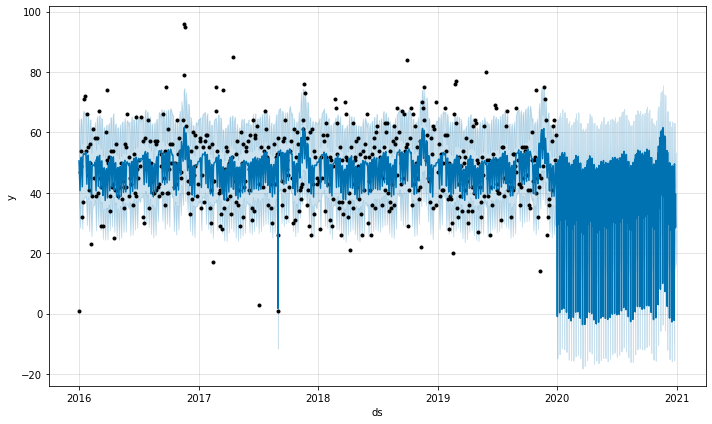

In [230]:
fig1 = m.plot(forecast)